### IMPORT

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression, Ridge,  Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeClassifier, export_graphviz

from sklearn.datasets import load_iris
from sklearn import tree

### FUNCTIONS

In [35]:
def Cleaning_function(path):
    
    df = pd.read_csv(path)

    df.loc[df.hauteurarbre == 'de 10 m à 20 m', 'hauteurarbre'] = 15
    df.loc[df.hauteurarbre == 'Moins de 10 m', 'hauteurarbre'] = 5
    df.loc[df.hauteurarbre == 'Plus de 20 m','hauteurarbre'] = 25
    df[['lat', 'long']] = df.geo_point_2d.str.split(",", expand = True).astype(float)

    to_drop = ['intituleprotectionplu','typeimplantationplu','traitementchenilles','genre','genre_desc','categorie','categorie_desc',
        'equipe','courrier','identifiantplu','identifiantplu','anneeabattage','essouchement','diametrearbre','causeabattage','remarques','raisondeplantation',
        'variete','stationmetro','structure','forme','typenature','portarbre','geo_point_2d']

    df_res = df.dropna(subset='anneedeplantation', inplace=True)
    df_res = df.drop(columns = to_drop)

    df_res.sous_categorie = df_res.sous_categorie.str[3:].astype('int64')
    df_res.code_parent = df_res.code_parent.str[3:].astype('int64')
    df_res.bien_reference = df_res.bien_reference.str[2:].astype('int64')
    df_res.code = df_res.code.str[3:].astype('int64')
    df_res.nom = df_res.nom.str[2:].astype('int64')

    df_res.to_pickle('C:/Users/eduard.vlasov/Documents/GitHub/ML/Data/cleaned_data_arbres.pkl')

    return df_res

In [112]:
# create pipelines, train, test and plot result
def create_evaluate_compare_pipeline(model_type, X_train, y_train, X_test, y_test, model_params=None):
    
    num_attribs = X_train.select_dtypes(include=np.number).columns.to_list()
    cat_attribs = X_train.select_dtypes(exclude=np.number).columns.to_list()

    numerical_transformer = Pipeline([
        ('imputer', KNNImputer(n_neighbors=5)),
        #('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        #('onehot', OneHotEncoder(handle_unknown='ignore'))
        ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ])

    preprocessor = ColumnTransformer([
        ("numerical", numerical_transformer, num_attribs),
        ("categorical", categorical_transformer, cat_attribs)
    ])

    if model_type == RandomForestClassifier:
        pipeline = Pipeline([
            ('pre', preprocessor),
            ('classifier', RandomForestClassifier(**model_params))
        ])
    elif model_type == RandomForestRegressor:
        pipeline = Pipeline([
            ('pre', preprocessor),
            ('random_forest', RandomForestRegressor(**model_params))
        ])
    elif model_type == LinearRegression:
        pipeline = Pipeline([
            ('pre', preprocessor),
            ('linear', LinearRegression())
        ])
    elif model_type == Ridge:
        pipeline = Pipeline([
            ('pre', preprocessor),
            ('ridge', Ridge(**model_params))
        ])
    # elif model_type == Lasso:
    #     pipeline = Lasso([
    #         ('pre', preprocessor),
    #         ('lasso', Lasso(**model_params))
    #     ])
    else:
        raise ValueError("Invalid model type. Supported types are RandomForestClassifier, RandomForestRegressor, and LinearRegression.")

    pipeline.fit(X_train, y_train)
    pipeline.predict(X_test)
    
    mae =  mean_absolute_error(y_test, pipeline.predict(X_test))
    mse = mean_squared_error(y_test, pipeline.predict(X_test)) 
    df_predict = pd.DataFrame({'Actual': y_test.anneedeplantation.to_numpy(), 'Predicted': pipeline.predict(X_test).ravel()})

    print(f'Training set accuracy {model_type}: {np.round(pipeline.score(X_train, y_train), 4)}')
    print(f'Test set accuracy {model_type}: {np.round(pipeline.score(X_test, y_test), 4)}')
    print(f'Mean Squared Error {model_type}: {np.round(mse, 4)}')
    print(f'Mean Absolute Error {model_type}: {np.round(mae, 4)}')

    plt.hist(df_predict['Actual'], label='Actual', alpha=1, color='black')
    plt.hist(df_predict['Predicted'], label='Predicted', alpha=0.6, histtype='stepfilled', color='steelblue', edgecolor='white', linewidth=2)
    plt.xlabel('YEAR')
    plt.title(f'Actual vs Predicted Values {model_type}')
    plt.legend()
    plt.show()

    return pipeline, df_predict, mse

In [115]:
#choosing best params of the model
def find_best_model_params(model_type, X_train, y_train, param_grid, cv=5, scoring='neg_mean_squared_error'):
    num_attribs = X_train.select_dtypes(include=np.number).columns.to_list()
    cat_attribs = X_train.select_dtypes(exclude=np.number).columns.to_list()
    
    numerical_transformer = Pipeline([
        ('imputer', KNNImputer(n_neighbors=5)),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ])

    preprocessor = ColumnTransformer([
        ("numerical", numerical_transformer, num_attribs),
        ("categorical", categorical_transformer, cat_attribs)
    ])

    if model_type == RandomForestClassifier:
        pipeline = Pipeline([
        ('pre', preprocessor),
        ('classifier', RandomForestClassifier())
    ])
    elif model_type == RandomForestRegressor:
        pipeline = Pipeline([
            ('pre', preprocessor),
            ('random_forest', RandomForestRegressor())
        ])
    elif model_type == LinearRegression:
        pipeline = Pipeline([
            ('pre', preprocessor),
            ('linear', LinearRegression())
        ])
    elif model_type == Ridge:
        pipeline = Pipeline([
            ('pre', preprocessor),
            ('ridge', Ridge())
        ])
    else:
        raise ValueError("Invalid model type. Supported types are RandomForestClassifier, RandomForestRegressor, and LinearRegression.")

    y_train = y_train['anneedeplantation'].ravel()

    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring=scoring)
    grid_search.fit(X_train, y_train) 

    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    stripped_best_params = {key.replace('classifier__', ''): value for key, value in best_params.items()}
    
    return stripped_best_params, best_model

### READING AND CLEANING

In [6]:
path = 'C:/Users/eduard.vlasov/Documents/GitHub/ML/Data/arbres_grenoble_epsg4326.csv'
df_res = Cleaning_function(path)

In [7]:
# sns.heatmap(df.isnull(), cbar=False)
# df.columns[df.isna().sum()>10000]
# df.loc[:, df.columns[df.isna().sum()>10000]].describe()#read cleaned csv

path='C:/Users/eduard.vlasov/Documents/GitHub/ML/Data/cleaned_data_arbres.pkl'
df_res = pd.read_pickle(path)

df_res.describe()

,elem_point_id,code,nom,sous_categorie,code_parent,adr_secteur,bien_reference,anneedeplantation,lat,long
count,30144.00000,30144.000000,30144.000000,30144.000000,30144.000000,30144.000000,30144.000000,30144.000000,30144.000000,30144.000000
mean,19142.18186,20209.518976,20209.518976,158.107285,2937.558386,3.828722,20209.518976,1990.018644,45.177280,5.727445
std,11824.16903,11164.956377,11164.956377,28.018516,8408.419032,1.706830,11164.956377,17.992314,0.011999,0.012782
min,1.00000,1428.000000,1428.000000,65.000000,7.000000,1.000000,1428.000000,1900.000000,45.151572,5.697915
25%,9180.75000,10667.750000,10667.750000,151.000000,393.000000,2.000000,10667.750000,1975.000000,45.166299,5.717668
50%,18469.50000,19910.500000,19910.500000,174.000000,748.500000,4.000000,19910.500000,1987.000000,45.175925,5.729491
75%,27800.25000,29194.250000,29194.250000,174.000000,1093.000000,5.000000,29194.250000,2006.000000,45.187461,5.737417
max,46658.00000,42115.000000,42115.000000,187.000000,41178.000000,6.000000,42115.000000,2022.000000,45.224825,5.798704


### VISIO

array([[<Axes: title={'center': 'anneedeplantation'}>]], dtype=object)

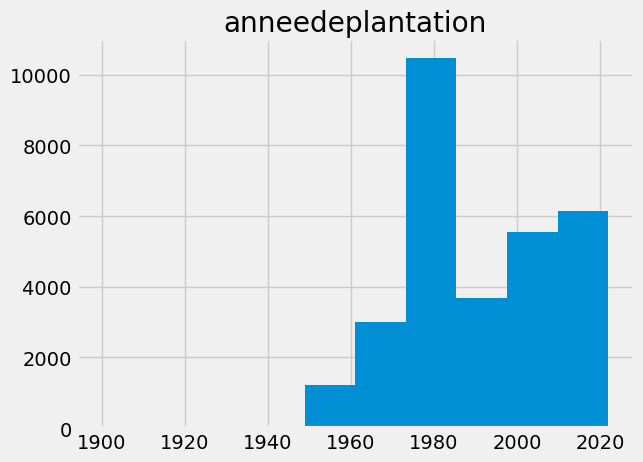

In [1106]:
#TOTAL BY THE YEAR
df_res.loc[:, ['anneedeplantation']].hist()

C:\Users\eduard.vlasov\AppData\Local\Temp\ipykernel_10968\2482591363.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_res["anneedeplantation"], color="b", label="Skewness : %.1f"%(df_res["anneedeplantation"].skew()))


<Axes: xlabel='anneedeplantation', ylabel='Density'>

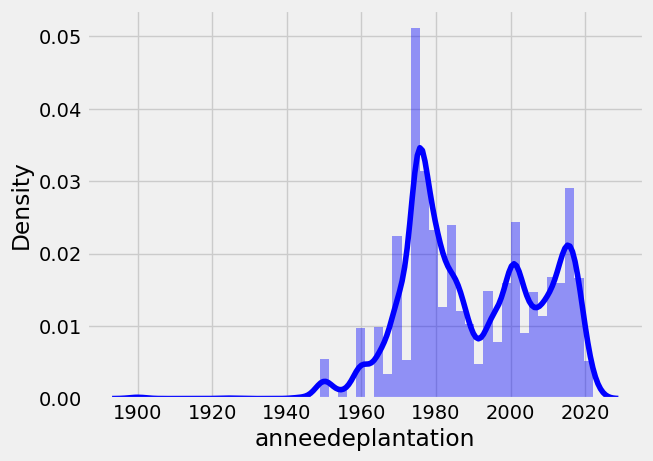

In [1107]:
sns.distplot(df_res["anneedeplantation"], color="b", label="Skewness : %.1f"%(df_res["anneedeplantation"].skew()))

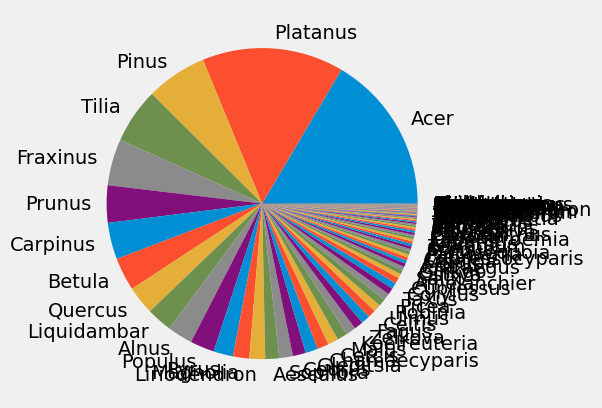

In [1108]:
#DOMINATION OF THE GENDER
data = df_res.genre_bota.value_counts().values
mylabels = df_res.genre_bota.value_counts().keys()


plt.pie(data, labels =mylabels)

plt.show() 

Text(0.5, 1.0, 'TOTAL PLANTED BY SOUS CATEGORIE')

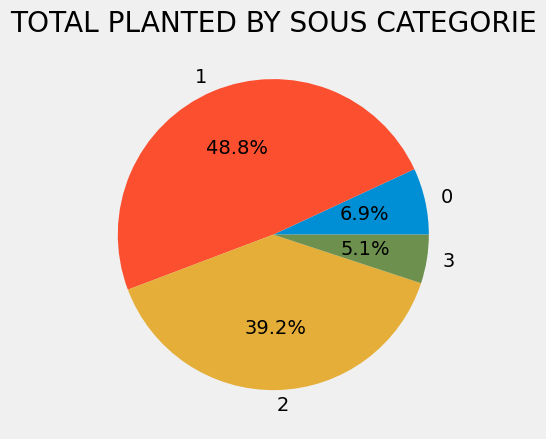

In [1109]:
#TOTAL PLANTED BY SOUS CATEGORIE
data = df_res.groupby('sous_categorie_desc')['anneedeplantation'].count()
plt.pie(data, labels =data.keys(), autopct='%1.1f%%')
plt.title('TOTAL PLANTED BY SOUS CATEGORIE')

Text(0.5, 1.0, 'TOTAL PLANTED BY AGE')

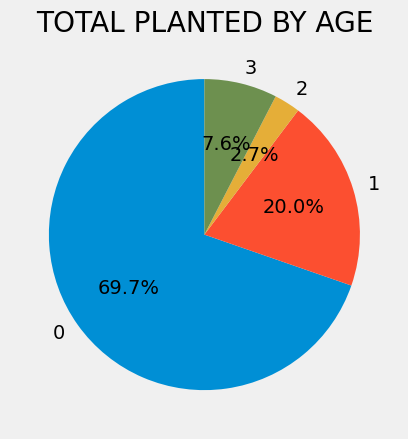

In [1110]:
#TOTAL PLANTED BY AGE
data = df_res.groupby('stadededeveloppement')['anneedeplantation'].count()
plt.pie(data,  labels = data.keys(), autopct='%1.1f%%', startangle=90)
plt.title('TOTAL PLANTED BY AGE')

In [1111]:
df_res.select_dtypes(include='number')

,elem_point_id,code,nom,sous_categorie,sous_categorie_desc,code_parent,adr_secteur,bien_reference,stadededeveloppement,anneedeplantation,hauteurarbre,lat,long
0,5259,11324,11324,151,2,175,5,11324,0,1975.0,15.0,45.175674,5.749421
1,1478,27796,27796,151,2,175,5,27796,0,1975.0,15.0,45.175689,5.749450
2,13139,4323,4323,174,1,1009,5,4323,0,1975.0,15.0,45.175403,5.748483
3,24132,7132,7132,174,1,1009,5,7132,0,1975.0,15.0,45.175424,5.748558
4,23970,15162,15162,174,1,625,5,15162,0,2009.0,5.0,45.177608,5.749357
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31731,18164,27355,27355,151,2,915,6,27355,0,2011.0,15.0,45.166626,5.725421
31732,18170,27356,27356,151,2,215,6,27356,1,2004.0,15.0,45.166508,5.724994
31733,18173,27357,27357,151,2,544,6,27357,0,1976.0,15.0,45.164310,5.723866
31734,18179,27358,27358,151,2,917,6,27358,0,1976.0,15.0,45.160543,5.723836


Text(0.5, 1.0, 'DEPENDENCES')

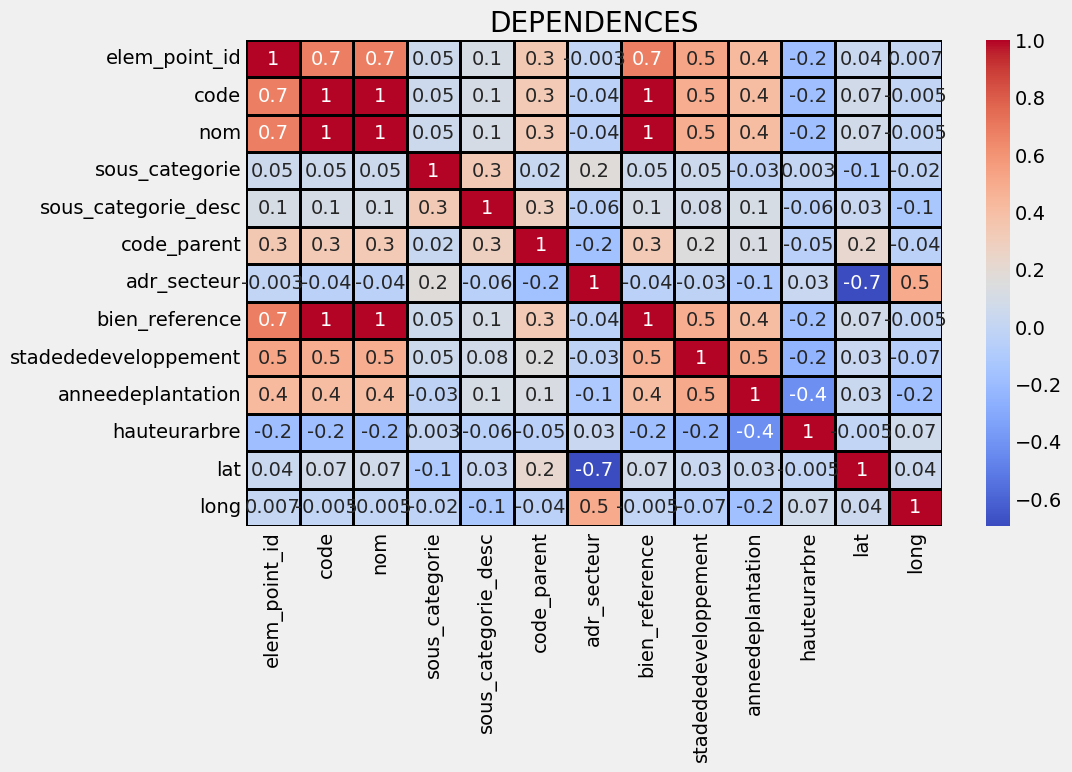

In [1112]:
plt.figure(figsize=(10,6))
dataplot = sns.heatmap(df_res.select_dtypes(include='number').corr(), annot=True, fmt='.1g', cmap= 'coolwarm', linecolor='black', linewidths=2)
plt.title('DEPENDENCES')

Text(0.5, 1.0, 'CONCENTRATION TREES BY THE COORDINATES')

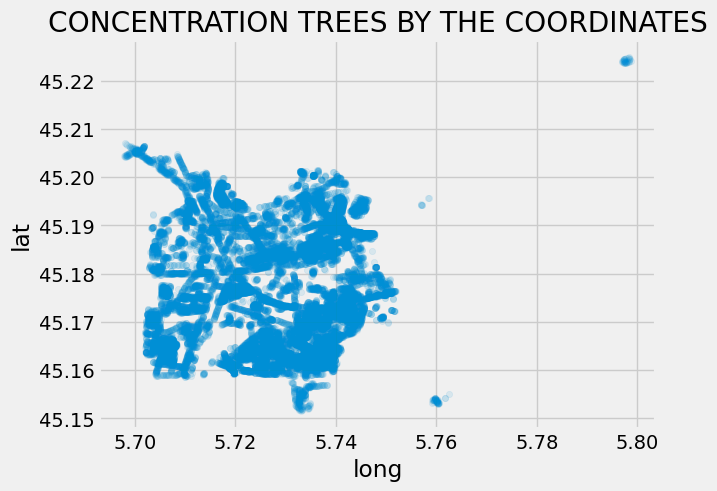

In [1113]:
df_res.plot(kind="scatter", x="long", y="lat", alpha=0.1)
plt.title('CONCENTRATION TREES BY THE COORDINATES')

### ITER 2

#### SELECT TRAIN TEST

In [27]:
# features = ['sous_categorie', 'sous_categorie_desc','adr_secteur', 'bien_reference', 'stadededeveloppement','hauteurarbre', 'lat', 'long']
# X = df_res.loc[:, features]
# y = df_res.loc[:, ['anneedeplantation']]
#SELECT TRAIN AND EST DATA

##!!!!!!!!!!!!!!!!!!! NEVER TOUCH TEST DATA !!!!!!!!!!!!!!!!!!!!!!

# X  = df_res.loc[:, df_res.columns !=  'anneedeplantation']
# y = df_res.loc[:, ['anneedeplantation']]


col_Nadia = ['sous_categorie', 'sous_categorie_desc','adr_secteur','genre_bota','espece','stadededeveloppement','anneedeplantation','collectivite','hauteurarbre','lat','long']


df_nadia = df_res.loc[:, col_Nadia]
X  = df_nadia.loc[:, df_nadia.columns !=  'anneedeplantation']
y = df_nadia.loc[:, ['anneedeplantation']]


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .80)

print(f'train subset of {len(X_train)} examples which are {len(X_train)/len(df_res)*100} % of all DATA')
print(f'test subset of {len(X_test)} examples which are {len(X_test)/len(df_res)*100} % of all DATA')


print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

train subset of 24115 examples which are 79.9993365180467 % of all DATA
test subset of 6029 examples which are 20.00066348195329 % of all DATA
Training Features Shape: (24115, 10)
Training Labels Shape: (24115, 1)
Testing Features Shape: (6029, 10)
Testing Labels Shape: (6029, 1)


#### Pipeline

In [266]:
# FOR TESTING

num_attribs = X.select_dtypes(include=np.number).columns.to_list()
cat_attribs = X.select_dtypes(exclude=np.number).columns.to_list()


numerical_transformer  = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
])

categorical_transformer  = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor  = ColumnTransformer([
        ("numerical", numerical_transformer, num_attribs),
        ("categorical", categorical_transformer, cat_attribs)
])

pipeline_RandomForestClassifier = Pipeline([
        ('pre', preprocessor),
        ('classifier', RandomForestClassifier())
])

pipeline_RandomForestRegressor = Pipeline([
        ('pre', preprocessor),
        ('random_forest', RandomForestRegressor(max_depth=10,random_state=2))
])

pipeline_LinearRegressor = Pipeline([
        ('pre', preprocessor),
        ('linear', LinearRegression())
])

#### TESTING FUNCTION W OneHotEncoder (ALL DATA)

c:\Users\eduard.vlasov\AppData\Local\anaconda3\envs\arbres\Lib\site-packages\sklearn\base.py:1215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Training set accuracy <class 'sklearn.ensemble._forest.RandomForestClassifier'>: 1.0
Test set accuracy <class 'sklearn.ensemble._forest.RandomForestClassifier'>: 0.9483
Mean Squared Error <class 'sklearn.ensemble._forest.RandomForestClassifier'>: 25.1236


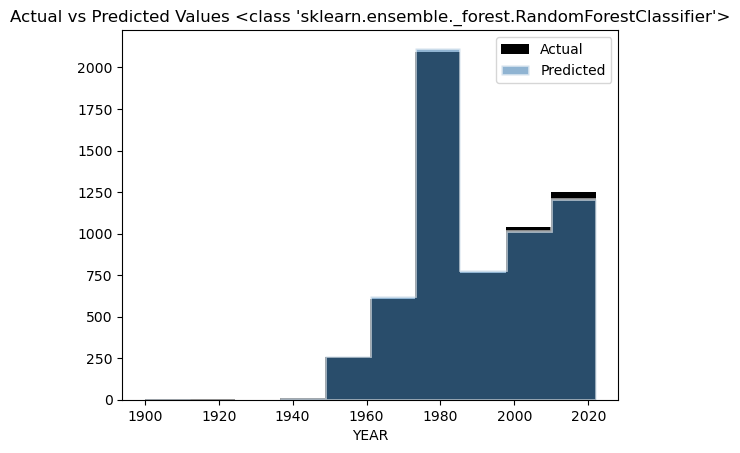

(Pipeline(steps=[('pre',
                  ColumnTransformer(transformers=[('numerical',
                                                   Pipeline(steps=[('imputer',
                                                                    KNNImputer()),
                                                                   ('scaler',
                                                                    StandardScaler())]),
                                                   ['elem_point_id', 'code',
                                                    'nom', 'sous_categorie',
                                                    'code_parent', 'adr_secteur',
                                                    'bien_reference', 'lat',
                                                    'long']),
                                                  ('categorical',
                                                   Pipeline(steps=[('imputer',
                                                              

In [33]:
create_evaluate_compare_pipeline(RandomForestClassifier, X_train,y_train,X_test,y_test)

c:\Users\eduard.vlasov\AppData\Local\anaconda3\envs\arbres\Lib\site-packages\sklearn\base.py:1215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Training set accuracy <class 'sklearn.ensemble._forest.RandomForestRegressor'>: 0.8058
Test set accuracy <class 'sklearn.ensemble._forest.RandomForestRegressor'>: 0.7846


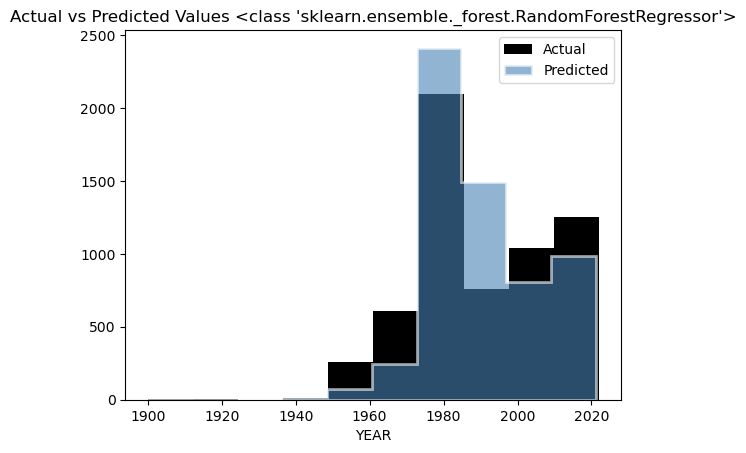

(Pipeline(steps=[('pre',
                  ColumnTransformer(transformers=[('numerical',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer()),
                                                                   ('scaler',
                                                                    StandardScaler())]),
                                                   ['elem_point_id', 'code',
                                                    'nom', 'sous_categorie',
                                                    'code_parent', 'adr_secteur',
                                                    'bien_reference', 'lat',
                                                    'long']),
                                                  ('categorical',
                                                   Pipeline(steps=[('imputer',
                                                           

In [ ]:
create_evaluate_compare_pipeline(RandomForestRegressor, X_train,y_train,X_test,y_test)

Training set accuracy <class 'sklearn.linear_model._base.LinearRegression'>: 0.8391
Test set accuracy <class 'sklearn.linear_model._base.LinearRegression'>: 0.7973


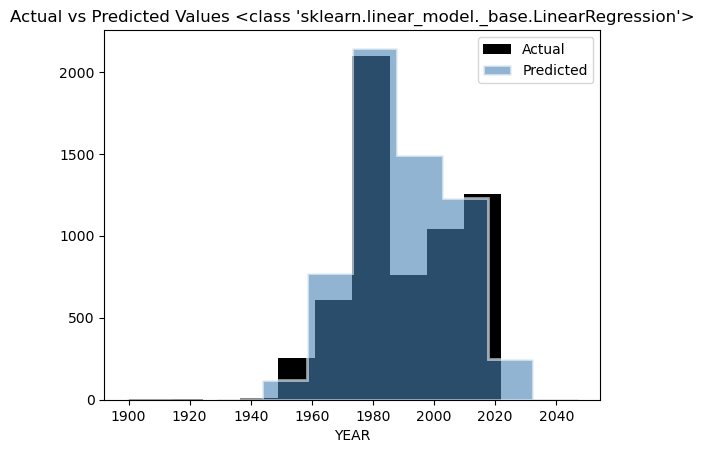

(Pipeline(steps=[('pre',
                  ColumnTransformer(transformers=[('numerical',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer()),
                                                                   ('scaler',
                                                                    StandardScaler())]),
                                                   ['elem_point_id', 'code',
                                                    'nom', 'sous_categorie',
                                                    'code_parent', 'adr_secteur',
                                                    'bien_reference', 'lat',
                                                    'long']),
                                                  ('categorical',
                                                   Pipeline(steps=[('imputer',
                                                           

In [ ]:
create_evaluate_compare_pipeline(LinearRegression, X_train,y_train,X_test,y_test)

#### TESTING FUNC + OrdinalEncoder() (ALL DATA)

Training set accuracy <class 'sklearn.linear_model._base.LinearRegression'>: 0.3843
Test set accuracy <class 'sklearn.linear_model._base.LinearRegression'>: 0.3931
Mean Squared Error <class 'sklearn.linear_model._base.LinearRegression'>: 198.7345


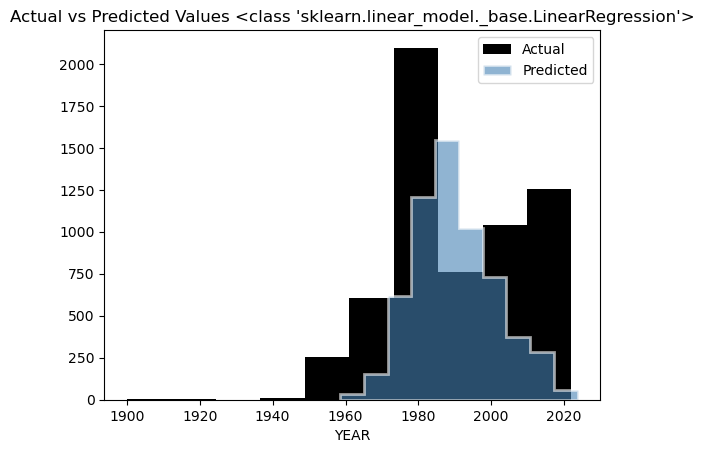

(Pipeline(steps=[('pre',
                  ColumnTransformer(transformers=[('numerical',
                                                   Pipeline(steps=[('imputer',
                                                                    KNNImputer()),
                                                                   ('scaler',
                                                                    StandardScaler())]),
                                                   ['elem_point_id', 'code',
                                                    'nom', 'sous_categorie',
                                                    'code_parent', 'adr_secteur',
                                                    'bien_reference', 'lat',
                                                    'long']),
                                                  ('categorical',
                                                   Pipeline(steps=[('imputer',
                                                              

In [34]:
create_evaluate_compare_pipeline(LinearRegression, X_train,y_train,X_test,y_test)

c:\Users\eduard.vlasov\AppData\Local\anaconda3\envs\arbres\Lib\site-packages\sklearn\base.py:1215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Training set accuracy <class 'sklearn.ensemble._forest.RandomForestClassifier'>: 1.0
Test set accuracy <class 'sklearn.ensemble._forest.RandomForestClassifier'>: 0.9492
Mean Squared Error <class 'sklearn.ensemble._forest.RandomForestClassifier'>: 23.9856


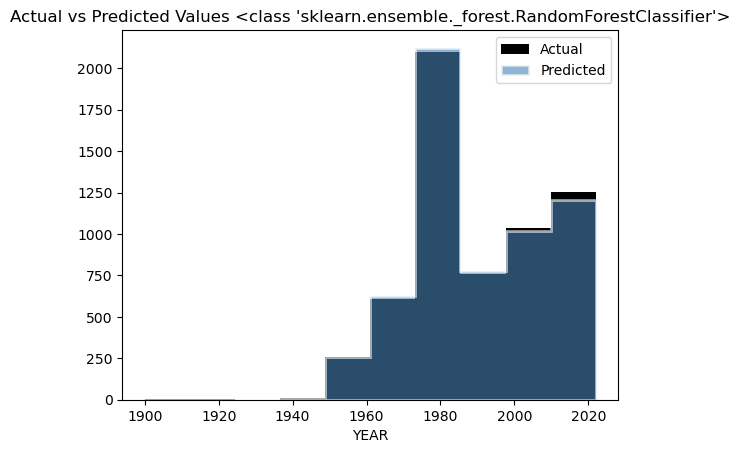

(Pipeline(steps=[('pre',
                  ColumnTransformer(transformers=[('numerical',
                                                   Pipeline(steps=[('imputer',
                                                                    KNNImputer()),
                                                                   ('scaler',
                                                                    StandardScaler())]),
                                                   ['elem_point_id', 'code',
                                                    'nom', 'sous_categorie',
                                                    'code_parent', 'adr_secteur',
                                                    'bien_reference', 'lat',
                                                    'long']),
                                                  ('categorical',
                                                   Pipeline(steps=[('imputer',
                                                              

In [35]:
create_evaluate_compare_pipeline(RandomForestClassifier, X_train,y_train,X_test,y_test)

c:\Users\eduard.vlasov\AppData\Local\anaconda3\envs\arbres\Lib\site-packages\sklearn\base.py:1215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Training set accuracy <class 'sklearn.ensemble._forest.RandomForestRegressor'>: 0.8639
Test set accuracy <class 'sklearn.ensemble._forest.RandomForestRegressor'>: 0.8381
Mean Squared Error <class 'sklearn.ensemble._forest.RandomForestRegressor'>: 53.0142


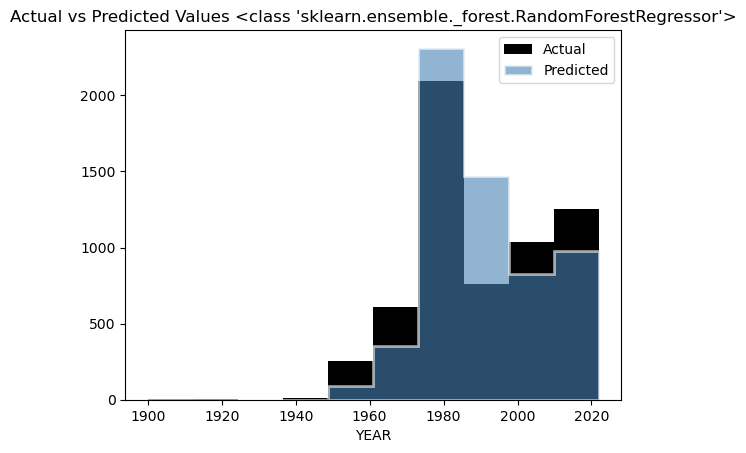

(Pipeline(steps=[('pre',
                  ColumnTransformer(transformers=[('numerical',
                                                   Pipeline(steps=[('imputer',
                                                                    KNNImputer()),
                                                                   ('scaler',
                                                                    StandardScaler())]),
                                                   ['elem_point_id', 'code',
                                                    'nom', 'sous_categorie',
                                                    'code_parent', 'adr_secteur',
                                                    'bien_reference', 'lat',
                                                    'long']),
                                                  ('categorical',
                                                   Pipeline(steps=[('imputer',
                                                              

In [36]:
create_evaluate_compare_pipeline(RandomForestRegressor, X_train,y_train,X_test,y_test)

c:\Users\eduard.vlasov\AppData\Local\anaconda3\envs\arbres\Lib\site-packages\sklearn\base.py:1215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Training set accuracy <class 'sklearn.ensemble._forest.RandomForestRegressor'>: 0.8639
Test set accuracy <class 'sklearn.ensemble._forest.RandomForestRegressor'>: 0.8381


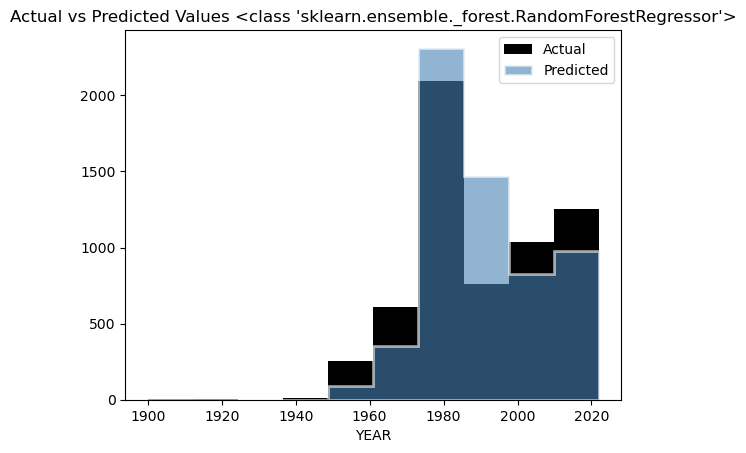

Training set accuracy <class 'sklearn.linear_model._base.LinearRegression'>: 0.3843
Test set accuracy <class 'sklearn.linear_model._base.LinearRegression'>: 0.3931


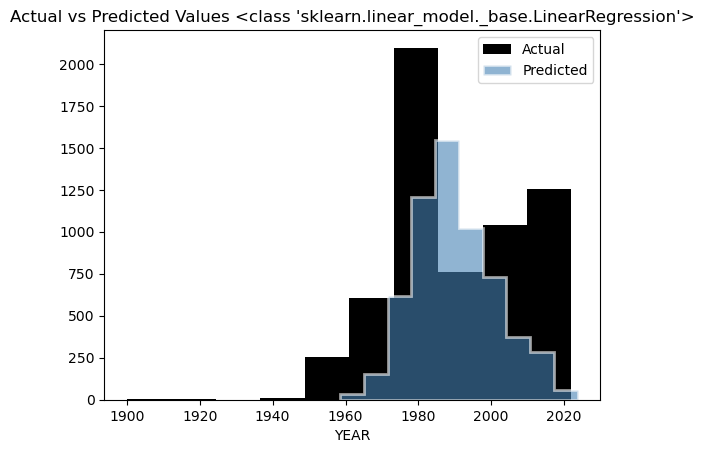

c:\Users\eduard.vlasov\AppData\Local\anaconda3\envs\arbres\Lib\site-packages\sklearn\base.py:1215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Training set accuracy <class 'sklearn.ensemble._forest.RandomForestClassifier'>: 1.0
Test set accuracy <class 'sklearn.ensemble._forest.RandomForestClassifier'>: 0.9461


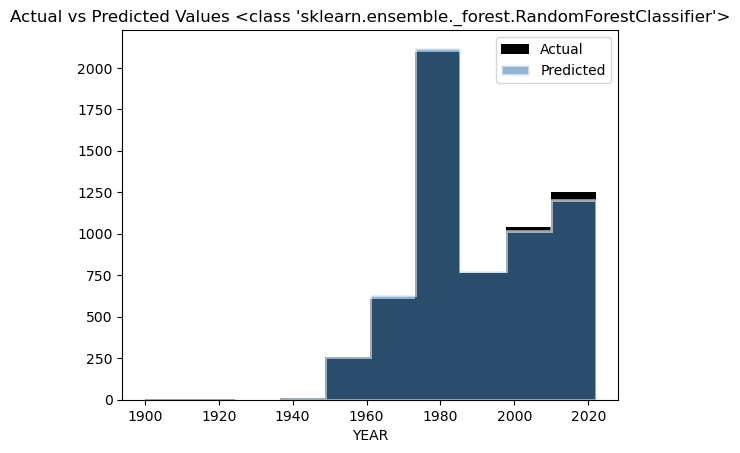

In [352]:
model_types = [RandomForestRegressor, LinearRegression, RandomForestClassifier]

for model_type in model_types:
    _, _, = create_evaluate_compare_pipeline(model_type, X_train, y_train, X_test, y_test)

#### TESTING FUNC + OrdinalEncoder() WITH SELECTED COLUMNS

Training set accuracy <class 'sklearn.linear_model._base.LinearRegression'>: 0.2521
Test set accuracy <class 'sklearn.linear_model._base.LinearRegression'>: 0.2569
Mean Squared Error <class 'sklearn.linear_model._base.LinearRegression'>: 243.3672
Mean Absolute Error <class 'sklearn.linear_model._base.LinearRegression'>: 12.5274


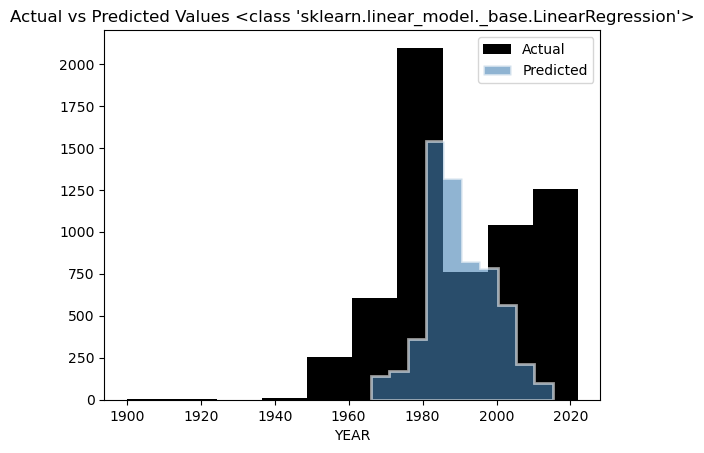

(Pipeline(steps=[('pre',
                  ColumnTransformer(transformers=[('numerical',
                                                   Pipeline(steps=[('imputer',
                                                                    KNNImputer()),
                                                                   ('scaler',
                                                                    StandardScaler())]),
                                                   ['sous_categorie',
                                                    'adr_secteur', 'lat',
                                                    'long']),
                                                  ('categorical',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer(strategy='most_frequent')),
                                                                   ('encoder',
                                          

In [54]:
create_evaluate_compare_pipeline(LinearRegression, X_train,y_train,X_test,y_test)

c:\Users\eduard.vlasov\AppData\Local\anaconda3\envs\arbres\Lib\site-packages\sklearn\base.py:1215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Training set accuracy <class 'sklearn.ensemble._forest.RandomForestClassifier'>: 1.0
Test set accuracy <class 'sklearn.ensemble._forest.RandomForestClassifier'>: 0.8894
Mean Squared Error <class 'sklearn.ensemble._forest.RandomForestClassifier'>: 53.5294
Mean Absolute Error <class 'sklearn.ensemble._forest.RandomForestClassifier'>: 1.7212


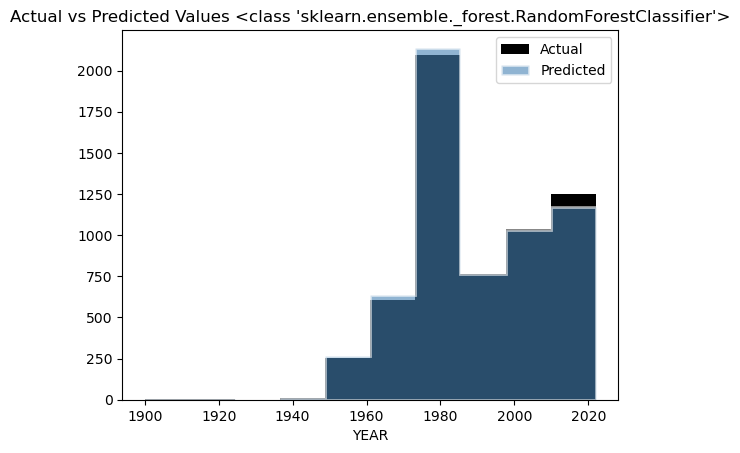

(Pipeline(steps=[('pre',
                  ColumnTransformer(transformers=[('numerical',
                                                   Pipeline(steps=[('imputer',
                                                                    KNNImputer()),
                                                                   ('scaler',
                                                                    StandardScaler())]),
                                                   ['sous_categorie',
                                                    'adr_secteur', 'lat',
                                                    'long']),
                                                  ('categorical',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer(strategy='most_frequent')),
                                                                   ('encoder',
                                          

In [57]:
create_evaluate_compare_pipeline(RandomForestClassifier, X_train,y_train,X_test,y_test)

c:\Users\eduard.vlasov\AppData\Local\anaconda3\envs\arbres\Lib\site-packages\sklearn\base.py:1215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Training set accuracy <class 'sklearn.ensemble._forest.RandomForestRegressor'>: 0.7501
Test set accuracy <class 'sklearn.ensemble._forest.RandomForestRegressor'>: 0.6948
Mean Squared Error <class 'sklearn.ensemble._forest.RandomForestRegressor'>: 99.9444
Mean Absolute Error <class 'sklearn.ensemble._forest.RandomForestRegressor'>: 6.8368


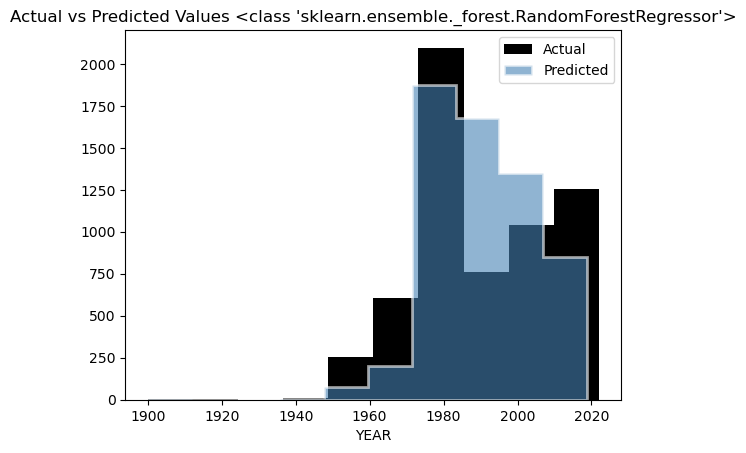

(Pipeline(steps=[('pre',
                  ColumnTransformer(transformers=[('numerical',
                                                   Pipeline(steps=[('imputer',
                                                                    KNNImputer()),
                                                                   ('scaler',
                                                                    StandardScaler())]),
                                                   ['sous_categorie',
                                                    'adr_secteur', 'lat',
                                                    'long']),
                                                  ('categorical',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer(strategy='most_frequent')),
                                                                   ('encoder',
                                          

In [58]:
create_evaluate_compare_pipeline(RandomForestRegressor, X_train,y_train,X_test,y_test)

#### OLD TESTS

In [269]:
pipeline_RandomForestClassifier.fit(X_train, y_train)

c:\Users\eduard.vlasov\AppData\Local\anaconda3\envs\arbres\Lib\site-packages\sklearn\base.py:1215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['elem_point_id', 'code',
                                                   'nom', 'sous_categorie',
                                                   'code_parent', 'adr_secteur',
                                                   'bien_reference', 'lat',
                                                   'long']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sous_categorie_desc',
                                                   'code_parent_desc',
                                                   'genre_bota', 'espece',
                                                   'stadededeveloppement',
                                                   'collectivite',
                                                   'hauteurarbre'])])),
                ('clf', RandomForestClassifier())])

In [297]:
pipeline_RandomForestClassifier.predict(X_test)

print('Training set accuracy RandomForestClassifier:', np.round(pipeline_RandomForestClassifier.score(X_train, y_train), 4))
print('Test set accuracy RandomForestClassifier:' , np.round(pipeline_RandomForestClassifier.score(X_test, y_test), 4))

Training set accuracy RandomForestClassifier: 1.0
Test set accuracy RandomForestClassifier: 0.9287


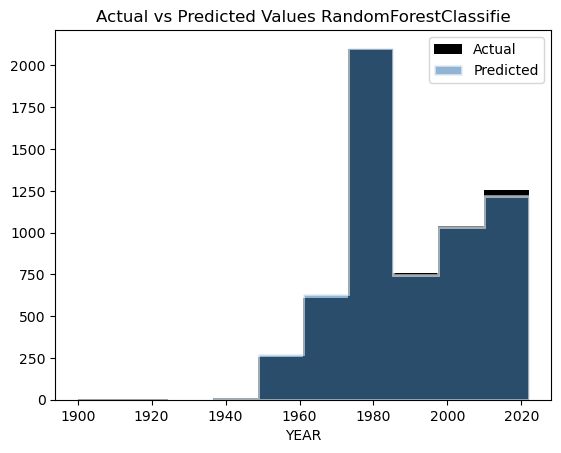

In [294]:
df_predict_RandomForestClassifier = pd.DataFrame({'Actual': y_test.anneedeplantation.to_numpy(), 'Predicted': pipeline_RandomForestClassifier.predict(X_test)})

plt.hist(df_predict_RandomForestClassifier['Actual'], label='Actual', alpha=1, color = 'black')
plt.hist(df_predict_RandomForestClassifier['Predicted'], label='Predicted',alpha=0.6, histtype='stepfilled', color='steelblue', edgecolor='white', linewidth=2)

plt.xlabel('YEAR')
plt.title('Actual vs Predicted Values RandomForestClassifie')
plt.legend()

plt.show()

In [267]:
pipeline_RandomForestRegressor.fit(X_train, y_train)

c:\Users\eduard.vlasov\AppData\Local\anaconda3\envs\arbres\Lib\site-packages\sklearn\base.py:1215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['elem_point_id', 'code',
                                                   'nom', 'sous_categorie',
                                                   'code_parent', 'adr_secteur',
                                                   'bien_reference', 'lat',
                                                   'long']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sous_categorie_desc',
                                                   'code_parent_desc',
                                                   'genre_bota', 'espece',
                                                   'stadededeveloppement',
                                                   'collectivite',
                                                   'hauteurarbre'])])),
                ('random_forest',
                 RandomForestRegressor(max_depth=10, random_state=2))])

In [298]:
pipeline_RandomForestRegressor.predict(X_test)

print('Training set accuracy RandomForestRegressor:', np.round(pipeline_RandomForestRegressor.score(X_train, y_train), 4))
print('Test set accuracy RandomForestRegressor:' , np.round(pipeline_RandomForestRegressor.score(X_test, y_test), 4))

Training set accuracy RandomForestRegressor: 0.8058
Test set accuracy RandomForestRegressor: 0.7846


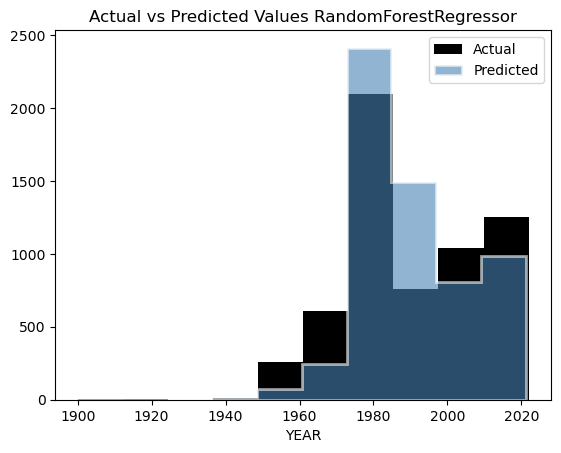

In [295]:
df_predict_RandomForestRegressor = pd.DataFrame({'Actual': y_test.anneedeplantation.to_numpy(), 'Predicted': pipeline_RandomForestRegressor.predict(X_test)})


plt.hist(df_predict_RandomForestRegressor['Actual'], label='Actual', alpha=1, color = 'black')
plt.hist(df_predict_RandomForestRegressor['Predicted'], label='Predicted',alpha=0.6, histtype='stepfilled', color='steelblue', edgecolor='white', linewidth=2)

plt.xlabel('YEAR')
plt.title('Actual vs Predicted Values RandomForestRegressor')
plt.legend()

plt.show()

In [272]:
pipeline_LinearRegressor.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['elem_point_id', 'code',
                                                   'nom', 'sous_categorie',
                                                   'code_parent', 'adr_secteur',
                                                   'bien_reference', 'lat',
                                                   'long']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sous_categorie_desc',
                                                   'code_parent_desc',
                                                   'genre_bota', 'espece',
                                                   'stadededeveloppement',
                                                   'collectivite',
                                                   'hauteurarbre'])])),
                ('linear', LinearRegression())])

In [301]:
pipeline_LinearRegressor.predict(X_test)

print('Training set accuracy LinearRegressor:', np.round(pipeline_LinearRegressor.score(X_train, y_train), 4))
print('Test set accuracy LinearRegressor:' , np.round(pipeline_LinearRegressor.score(X_test, y_test), 4))

Training set accuracy LinearRegressor: 0.8391
Test set accuracy LinearRegressor: 0.7973


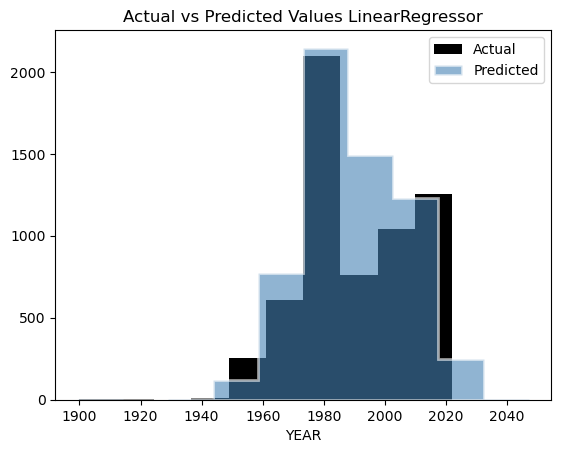

In [307]:
df_predict_LinearRegressor = pd.DataFrame({'Actual': y_test.anneedeplantation.to_numpy(), 'Predicted': pipeline_LinearRegressor.predict(X_test).ravel()})


plt.hist(df_predict_LinearRegressor['Actual'], label='Actual', alpha=1, color = 'black')
plt.hist(df_predict_LinearRegressor['Predicted'], label='Predicted',alpha=0.6, histtype='stepfilled', color='steelblue', edgecolor='white', linewidth=2)

plt.xlabel('YEAR')
plt.title('Actual vs Predicted Values LinearRegressor')
plt.legend()

plt.show()

#### DecisionTreeRegressor

In [1270]:
#REGRESSION !!!DIFF DEPTH!!!

# List of values to try for max_depth:
max_depth_range = list(range(1, 25))

# List to store the average RMSE for each value of max_depth:
r2_test_list = []
r2_train_list = []

for depth in max_depth_range:
    
    reg = DecisionTreeRegressor(max_depth = depth, 
                             random_state = 0)
    reg.fit(X_train, y_train)    
    
    score = reg.score(X_test, y_test)
    r2_test_list.append(score)
    
    # Bad practice: train and test the model on the same data
    score = reg.score(X_train, y_train)
    r2_train_list.append(score)

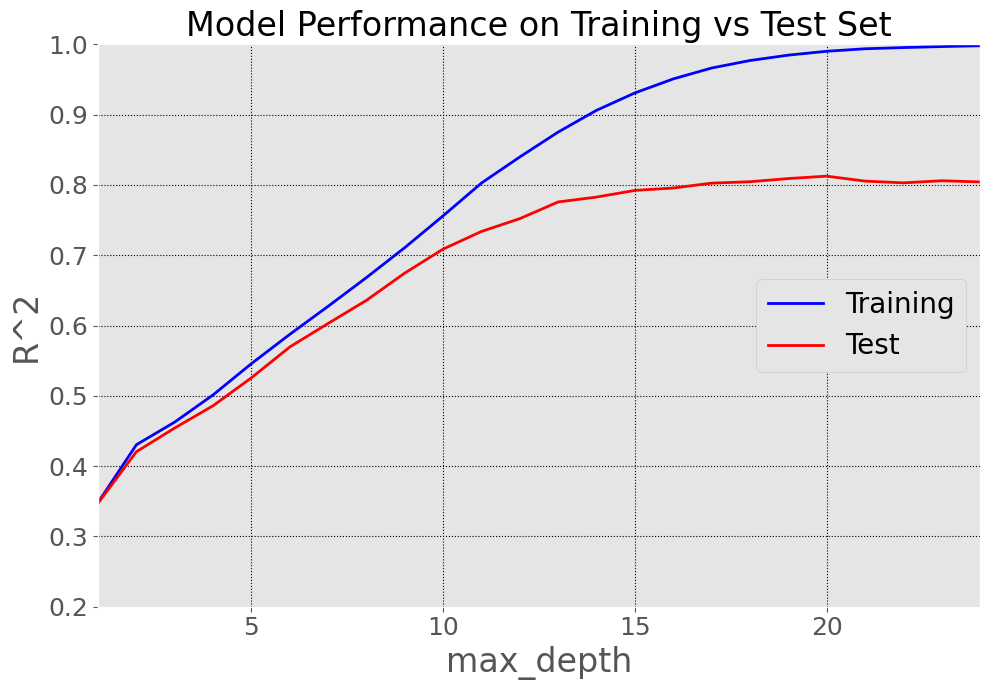

In [1271]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10,7), facecolor = 'white');

ax.plot(max_depth_range,
        r2_train_list,
        lw=2,
        color='b',
        label = 'Training')

ax.plot(max_depth_range,
        r2_test_list,
        lw=2,
        color='r',
        label = 'Test')

ax.set_xlim([1, max(max_depth_range)])
ax.grid(True,
        axis = 'both',
        zorder = 0,
        linestyle = ':',
        color = 'k')
ax.tick_params(labelsize = 18)
ax.set_xlabel('max_depth', fontsize = 24)
ax.set_ylabel('R^2', fontsize = 24)
ax.set_ylim(.2,1)

ax.legend(loc = 'center right', fontsize = 20, framealpha = 1)


ax.set_title('Model Performance on Training vs Test Set', fontsize = 24)


temp = ax.get_xlim()
temp1 = ax.get_ylim()

fig.tight_layout()
#fig.savefig('images/max_depth_vs_R2_Best_Model.png', dpi = 300)

In [1287]:
#FIT
reg = DecisionTreeRegressor(max_depth = 12, random_state = 0)
reg.fit(X_train, y_train)

#PREDICTION TEST
y_pred = reg.predict(X_test)
score = reg.score(X_test, y_test)
print(score)

0.7520624921802023


In [1288]:
df_predict_trees = pd.DataFrame({'Actual': y_test.anneedeplantation.to_numpy(), 'Predicted': y_pred})



plt.hist(df_predict_trees['Actual'], label='Actual')
plt.hist(df_predict_trees['Predicted'], label='Predicted', alpha=0.4)

plt.xlabel('YEAR')
plt.title('Actual vs Predicted Values DecisionTreeRegressor')
plt.legend()

plt.show()

,Actual,Predicted
0,1960.0,1982.595276
1,1960.0,1971.142857
2,1977.0,1982.595276
3,1975.0,1969.274194
4,2003.0,2003.076923
...,...,...
5746,1999.0,1997.412281
5747,1976.0,1975.140741
5748,1975.0,1976.216049
5749,1970.0,1974.400000


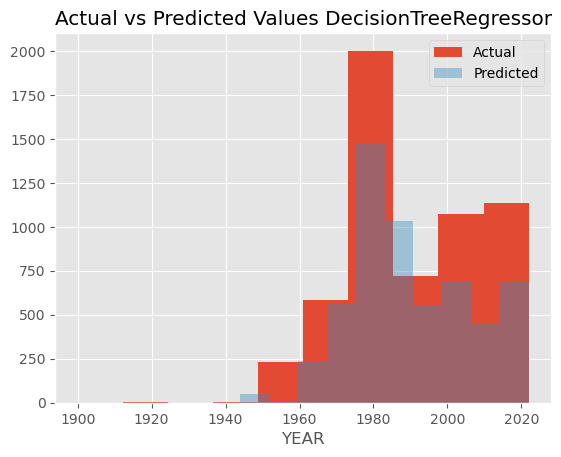

#### Random Forest Regression

In [1290]:
# features = ['sous_categorie', 'sous_categorie_desc','adr_secteur', 'bien_reference', 'stadededeveloppement','hauteurarbre', 'lat', 'long']
# X = df_res.loc[:, features]
# y = df_res.loc[:, ['anneedeplantation']]

X  = df_numeric.loc[:, df_numeric.columns !=  'anneedeplantation']
y = df_numeric.loc[:, ['anneedeplantation']]

In [1292]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 0)
rf.fit(X_train, y_train)

c:\Users\eduard.vlasov\AppData\Local\anaconda3\envs\arbres\Lib\site-packages\sklearn\base.py:1215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(random_state=0)

In [1293]:
# Calculate the mean absolute error (mae)

predictions = rf.predict(X_test)
errors = abs(predictions - y_test.anneedeplantation.to_numpy())
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 2.46 degrees.


In [1294]:
# Calculate mean absolute percentage error (MAPE)

mape = 100 * (errors / y_test.anneedeplantation.to_numpy())

accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 99.88 %.


In [1295]:
df_predict_RFR = pd.DataFrame({'Actual': y_test.anneedeplantation.to_numpy(dtype=list), 'Predicted': predictions})
df_predict_RFR

,Actual,Predicted
0,1960.0,1977.78
1,1960.0,1965.42
2,1977.0,1977.28
3,1975.0,1975.32
4,2003.0,2002.88
...,...,...
5746,1999.0,1999.00
5747,1976.0,1976.00
5748,1975.0,1975.30
5749,1970.0,1972.21


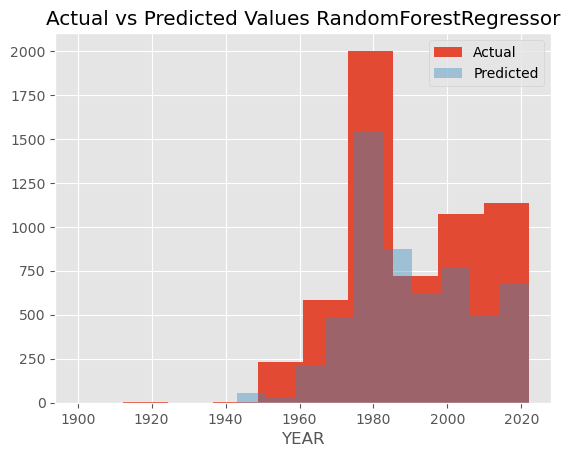

In [1296]:
plt.hist(df_predict_RFR['Actual'], label='Actual')
plt.hist(df_predict_RFR['Predicted'], label='Predicted', alpha=0.4)

plt.xlabel('YEAR')
plt.title('Actual vs Predicted Values RandomForestRegressor')
plt.legend()


#### Linear Regression

In [1297]:
df_numeric = df_res.select_dtypes(include='number')

In [1298]:
X  = df_numeric.loc[:, df_numeric.columns !=  'anneedeplantation']
y = df_numeric.loc[:, ['anneedeplantation']]


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .80)

In [1299]:
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [1300]:
r_sq = model.score(X_train, y_train)
print(r_sq)
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")

0.42321934795934246
intercept: [2193.35108231]
slope: [[ 2.15512936e-04  6.48658645e-05  6.48658856e-05 -3.96384359e-02
   9.73260739e-01 -1.05186142e-04 -3.06999587e-01  6.48658860e-05
   1.47364949e-02  6.19933109e+00 -2.95676489e+00 -8.70151965e-01
   1.43259955e+01 -1.47437106e+02]]


In [1301]:
predictions = model.predict(X_test)

In [1302]:
df_predict_LINEAR = pd.DataFrame({'Actual': y_test.anneedeplantation.to_numpy(), 'Predicted': predictions.ravel()})
df_predict_LINEAR

,Actual,Predicted
0,2014.0,2007.062102
1,1984.0,1986.899832
2,2016.0,2018.698157
3,2005.0,1990.689452
4,2015.0,2000.130973
...,...,...
6024,1997.0,1991.769992
6025,1982.0,1999.338588
6026,1975.0,1989.114924
6027,1976.0,1979.761250


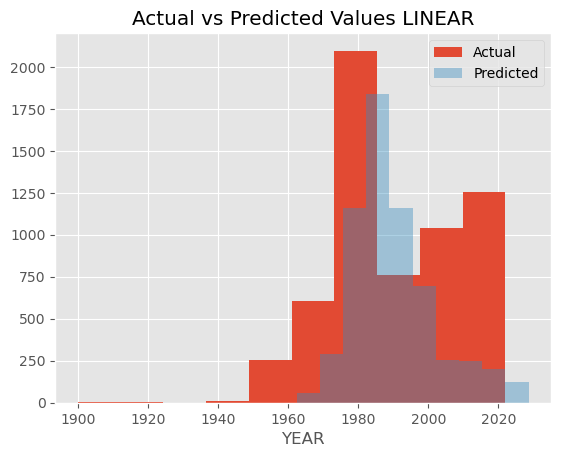

In [1303]:
plt.hist(df_predict_LINEAR['Actual'], label='Actual')
plt.hist(df_predict_LINEAR['Predicted'], label='Predicted', alpha=0.4)

plt.xlabel('YEAR')
plt.title('Actual vs Predicted Values LINEAR')
plt.legend()

plt.show()

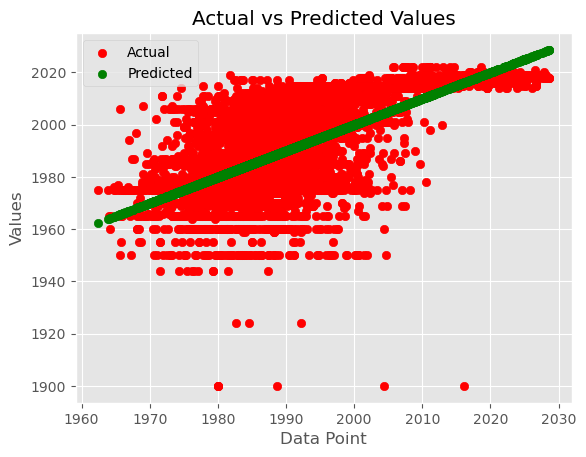

In [1324]:
plt.scatter(predictions, df_predict_LINEAR.Actual, color='red', label='Actual')
plt.scatter(predictions, df_predict_LINEAR.Predicted, color='green', label='Predicted')

# Adding labels and title
plt.xlabel('Data Point')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.legend()

# Show the plot
plt.show()

#### OPTIMISATION RFC


In [10]:
X.head()

,sous_categorie,sous_categorie_desc,adr_secteur,genre_bota,espece,stadededeveloppement,collectivite,hauteurarbre,lat,long
0,151,Arbre de voirie,5,Robinia,pseudoacacia,Arbre adulte,Grenoble Alpes Métropole,NaN,45.175674,5.749421
1,151,Arbre de voirie,5,Acer,campestre,Arbre adulte,Grenoble Alpes Métropole,NaN,45.175689,5.749450
2,174,Arbre d'espaces ouverts,5,Fraxinus,americana,Arbre adulte,Grenoble Alpes Métropole,15,45.175403,5.748483
3,174,Arbre d'espaces ouverts,5,Fraxinus,americana,Arbre adulte,Ville de Grenoble,15,45.175424,5.748558
4,174,Arbre d'espaces ouverts,5,Prunus,avium,Arbre adulte,Ville de Grenoble,5,45.177608,5.749357


In [15]:
cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

array([-69.65415716, -53.89715944, -63.18971594, -63.13186813,
       -63.59154053])

c:\Users\eduard.vlasov\AppData\Local\anaconda3\envs\arbres\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 5}


c:\Users\eduard.vlasov\AppData\Local\anaconda3\envs\arbres\Lib\site-packages\sklearn\base.py:1215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Training set accuracy <class 'sklearn.ensemble._forest.RandomForestClassifier'>: 0.9541
Test set accuracy <class 'sklearn.ensemble._forest.RandomForestClassifier'>: 0.8524
Mean Squared Error <class 'sklearn.ensemble._forest.RandomForestClassifier'>: 76.0537
Mean Absolute Error <class 'sklearn.ensemble._forest.RandomForestClassifier'>: 2.4691


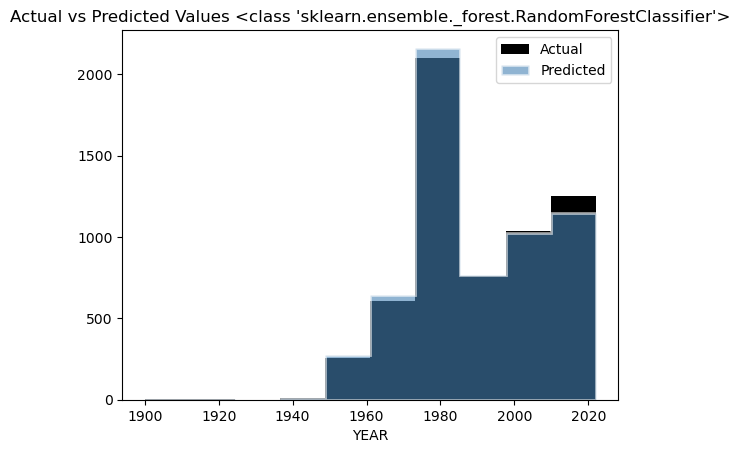

In [76]:
param_grid = {
    'classifier__n_estimators': [5],
    'classifier__max_depth': [None, 10],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}



best_params, best_model = find_best_model_params(RandomForestClassifier, X_train, y_train, param_grid)
print("Best Parameters:", best_params)

pipeline, df_predict, mse = create_evaluate_compare_pipeline(RandomForestClassifier, X_train, y_train, X_test, y_test, model_params=best_params)

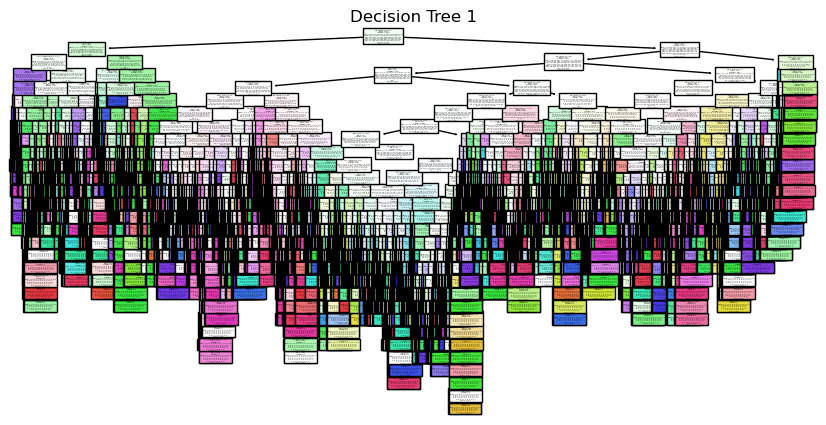

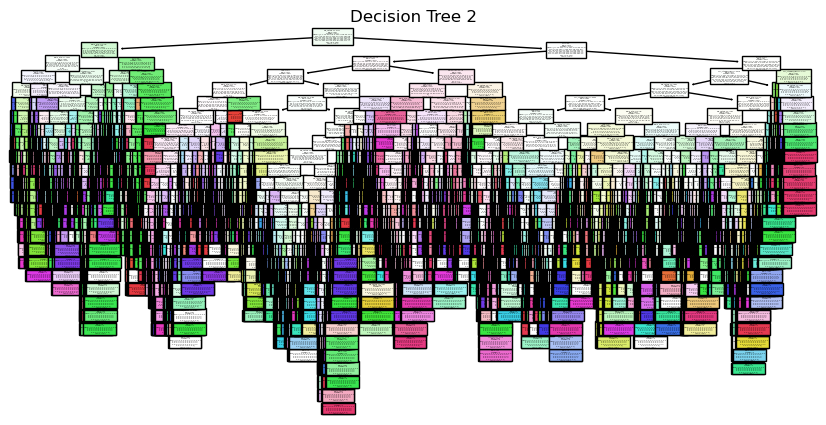

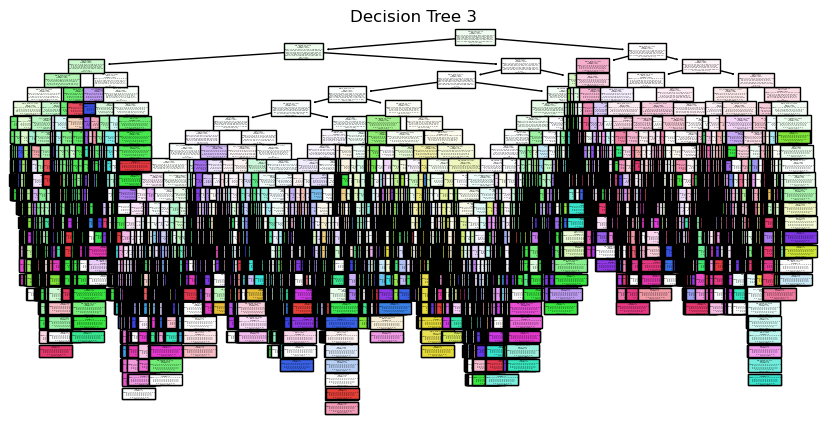

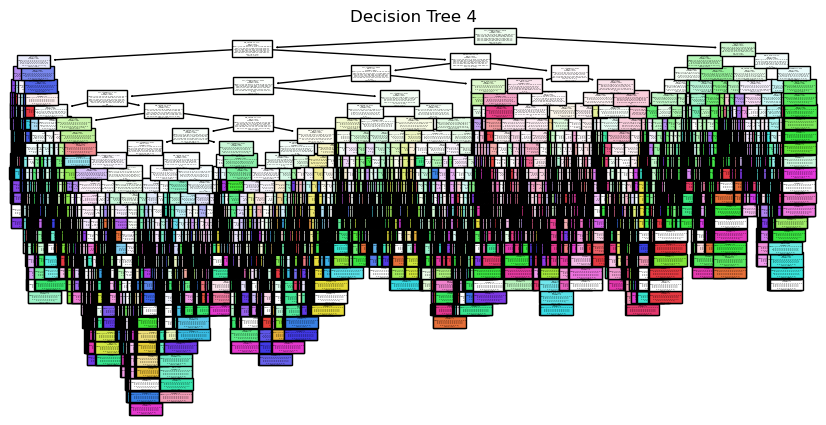

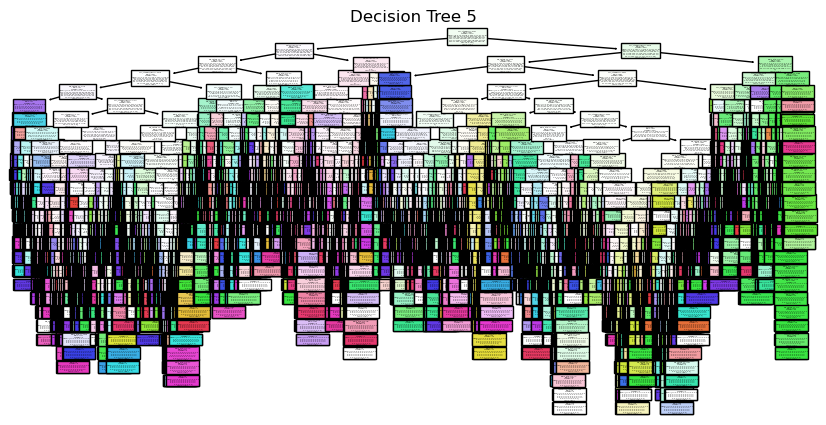

In [77]:
for tree_idx, est in enumerate(pipeline.named_steps['classifier'].estimators_):
    plt.figure(figsize=(10, 5))
    tree.plot_tree(est, filled=True, feature_names=X_train.columns, class_names=[str(i) for i in pipeline.classes_])
    plt.title(f'Decision Tree {tree_idx + 1}')
    plt.show()

In [78]:
pipeline

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['sous_categorie',
                                                   'adr_secteur', 'lat',
                                                   'long']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['sous_categorie_desc',
                                                   'genre_bota', 'espece',
                                                   'stadededeveloppement',
                                                   'collectivite',
                                                   'hauteurarbre'])])),
                ('classifier',
                 RandomForestClassifier(min_samples_split=5, n_estimators=5))])

### TEST RIDGE

Training set accuracy <class 'sklearn.linear_model._ridge.Ridge'>: 0.2521
Test set accuracy <class 'sklearn.linear_model._ridge.Ridge'>: 0.2569
Mean Squared Error <class 'sklearn.linear_model._ridge.Ridge'>: 243.3672
Mean Absolute Error <class 'sklearn.linear_model._ridge.Ridge'>: 12.5274


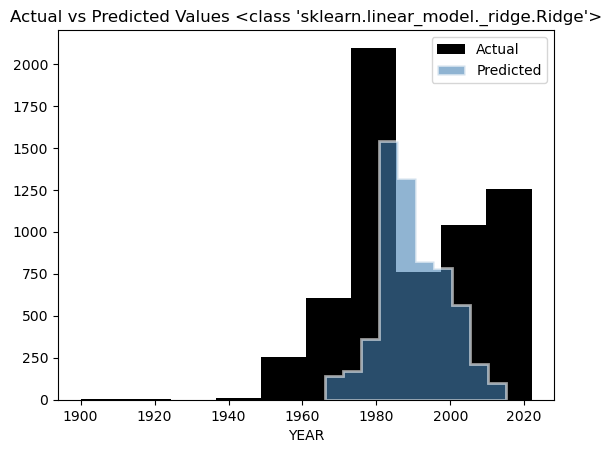

(Pipeline(steps=[('pre',
                  ColumnTransformer(transformers=[('numerical',
                                                   Pipeline(steps=[('imputer',
                                                                    KNNImputer()),
                                                                   ('scaler',
                                                                    StandardScaler())]),
                                                   ['sous_categorie',
                                                    'adr_secteur', 'lat',
                                                    'long']),
                                                  ('categorical',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer(strategy='most_frequent')),
                                                                   ('encoder',
                                          

In [114]:
model_params = {'alpha': 10**(-7)} 

create_evaluate_compare_pipeline(Ridge, X_train,y_train,X_test,y_test, model_params=model_params)